<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [20]:
%load_ext autoreload
%autoreload 2
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt 
sys.path.insert(0, '../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# %%capture
from feature_valuation.explainers import ExactNew
import shap
import xgboost
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [22]:
# %%capture
def bool2int(x):
    y = 0
    for i, j in enumerate(x):
        y += j << i
    return y


def cal(model, X, y, data_idx=1, type='fg',tempe=0.1):
    
    col_idx = 1 if y[data_idx] else 0
    #print(f"type: {type}")
          
    if type == "random":
        explainer = ExactNew(model.predict_proba, X, type="shap",tempe=tempe)
    else:
        explainer = ExactNew(model.predict_proba, X, type=type,tempe=tempe)
        
    # calculate values given data_idx
    shap_values = explainer(X[data_idx:data_idx + 1])  # 100 * 12 * 2
    shap_values = shap_values[..., col_idx]
    if type == "fg":
        shap_values.values = np.log(np.divide(shap_values.values, (1 - shap_values.values)))
    #print(shap_values.values)
    if type != "random":
        abs_values = -shap_values.values
        mask_idx = np.argsort(abs_values)
    else:
        mask_idx = [np.random.permutation(12)]
    #print(mask_idx)
    #print(shap_values.values)

    # Construct the mask.
    v = len(mask_idx[0])
    bin_mask = [1] * v
    real_idxs = [bool2int(bin_mask[::-1])]
    res = [explainer.all_outputs[real_idxs[0]][col_idx]]
    
    for idx in mask_idx[0]:
        bin_mask[int(idx)] = 0
        real_idx = bool2int(bin_mask[::-1])
        real_idxs.append(real_idx)
        res.append(explainer.all_outputs[real_idx][col_idx])
        #print(res[-1])

    res = np.array(res)
    #print(res.shape)
    #res = np.abs(res-res[0])

    shap_values.base_values = shap_values.base_values[0]
    shap_values.values = shap_values.values[0]
    shap_values.data = shap_values.data[0]
    return res, shap_values


In [25]:
#%%capture
def main(model, data_idx=2, tempe=0.1):
    # get a dataset on income prediction
    X, y = shap.datasets.adult()

    rand_diff, rand_coff = cal(model, X, y, data_idx=data_idx, type="random",tempe=tempe)
    shap_diff, shap_coff = cal(model, X, y, data_idx=data_idx, type="shap", tempe=tempe)
    banz_diff, banz_coff = cal(model, X, y, data_idx=data_idx, type="banz", tempe=tempe)
    fg_diff, fg_coff = cal(model, X, y, data_idx=data_idx, type="fg", tempe=tempe)
    
    
    res = np.vstack((rand_diff, shap_diff, banz_diff, fg_diff))
    coff = [rand_coff, shap_coff, banz_coff, fg_coff]
    #print(res)
    return res, coff


X, y = shap.datasets.adult()
# train an XGBoost model (but any other model type would also work)
model = xgboost.XGBClassifier()
model.fit(X, y)
# the last of coff is variational index
res, coff = main(model, 1, 0.1)

[11:04:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Epoch: 100%|██████████| 120/120 [00:00<00:00, 442.49it/s]

iter=0;diff=0.04063225939058425;time=0.00223494
iter=1;diff=0.01401054778045315;time=0.00215888
iter=2;diff=0.003890131679961642;time=0.00213313
iter=3;diff=0.0012817601227037357;time=0.00212908
iter=4;diff=0.00039062245229957293;time=0.00209928
iter=5;diff=0.0001241547345927179;time=0.00211573
iter=6;diff=3.8680458283553124e-05;time=0.00209284
iter=7;diff=1.2173648433960757e-05;time=0.00221562
iter=8;diff=3.812406070769395e-06;time=0.00213790
iter=9;diff=1.1968772764111691e-06;time=0.00212336
iter=10;diff=3.7529331320432136e-07;time=0.00211835
iter=11;diff=1.1774833659231797e-07;time=0.00209236
iter=12;diff=3.6932489866498304e-08;time=0.00211263
iter=13;diff=1.1585824945577009e-08;time=0.00211763
iter=14;diff=3.6342375729586114e-09;time=0.00213957
iter=15;diff=1.140028093213196e-09;time=0.00210190
iter=16;diff=3.576102005350967e-10;time=0.00213432
iter=17;diff=1.1217813438031989e-10;time=0.00211668
iter=18;diff=3.518881568675795e-11;time=0.00211501
iter=19;diff=1.1038278555664468e-11;


Epoch: 100%|██████████| 120/120 [00:00<00:00, 442.05it/s]

iter=0;diff=0.040632259370682995;time=0.00221419
iter=1;diff=0.015913569388645788;time=0.00213194
iter=2;diff=0.005711336642477763;time=0.00210667
iter=3;diff=0.0021764647048124193;time=0.00209188
iter=4;diff=0.000798832814336763;time=0.00210428
iter=5;diff=0.00029341677952744087;time=0.00210404
iter=6;diff=0.00010727831039218653;time=0.00209045
iter=7;diff=3.9215248041308463e-05;time=0.00213504
iter=8;diff=1.4325833528801076e-05;time=0.00210905
iter=9;diff=5.233380566013282e-06;time=0.00212669
iter=10;diff=1.911612185216088e-06;time=0.00209808
iter=11;diff=6.982662118918107e-07;time=0.00210428
iter=12;diff=2.550551432600803e-07;time=0.00208163
iter=13;diff=9.316412882074928e-08;time=0.00212908
iter=14;diff=3.402998368529999e-08;time=0.00209618
iter=15;diff=1.2430117333646753e-08;time=0.00209689
iter=16;diff=4.540339949941307e-09;time=0.00210333
iter=17;diff=1.6584471008194133e-09;time=0.00208807
iter=18;diff=6.05779906688526e-10;time=0.00211883
iter=19;diff=2.2127278929329354e-10;time

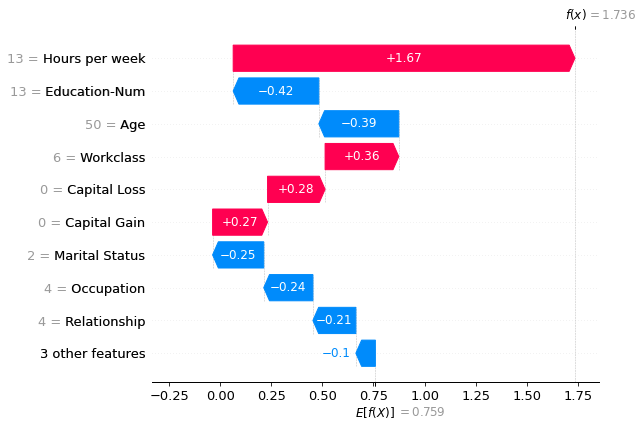

In [26]:
%matplotlib inline
# plot the variational index
shap.plots.waterfall(coff[3]);